In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Thu Jun 23 23:48:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   53C    P2    78W / 260W |   4535MiB / 11019MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 26%   

# LDA

## 2015 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2015.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(8933 unique tokens: ['一种', '中央处理单元', '主人', '传感器', '体内']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.292989,1469.957146
1,3,-7.252186,1411.186104
2,4,-7.239417,1393.281540
3,5,-7.231500,1382.294102
4,6,-7.223698,1371.551270
5,7,-7.219028,1365.160940
6,8,-7.215222,1359.976174
7,9,-7.195037,1332.800138
8,10,-7.187466,1322.747740
9,11,-7.183222,1317.145707


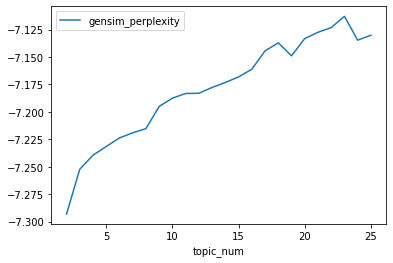

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.292989,1469.957146
1,3,-7.252186,1411.186104
2,4,-7.239417,1393.281540
3,5,-7.231500,1382.294102
4,6,-7.223698,1371.551270
5,7,-7.219028,1365.160940
6,8,-7.215222,1359.976174
7,9,-7.195037,1332.800138
8,10,-7.187466,1322.747740
9,11,-7.183222,1317.145707


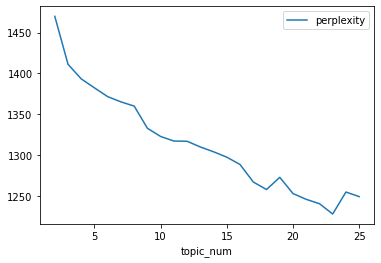

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2015.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

16

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[16,
 2,
 2,
 14,
 7,
 16,
 7,
 7,
 2,
 11,
 7,
 20,
 8,
 21,
 7,
 11,
 2,
 13,
 11,
 21,
 20,
 20,
 11,
 10,
 11,
 20,
 13,
 2,
 13,
 17,
 11,
 10,
 5,
 14,
 15,
 2,
 2,
 21,
 11,
 2,
 21,
 21,
 11,
 2,
 11,
 21,
 6,
 7,
 13,
 21,
 6,
 10,
 2,
 6,
 2,
 8,
 2,
 13,
 17,
 6,
 16,
 0,
 13,
 9,
 10,
 13,
 2,
 19,
 7,
 4,
 7,
 19,
 2,
 3,
 18,
 18,
 21,
 0,
 8,
 10,
 15,
 2,
 20,
 7,
 4,
 3,
 11,
 5,
 2,
 11,
 21,
 10,
 20,
 11,
 11,
 21,
 19,
 8,
 10,
 19,
 4,
 11,
 11,
 5,
 2,
 21,
 16,
 10,
 11,
 2,
 11,
 20,
 3,
 8,
 5,
 7,
 20,
 21,
 20,
 18,
 19,
 18,
 3,
 2,
 11,
 18,
 9,
 18,
 6,
 11,
 4,
 11,
 9,
 6,
 10,
 11,
 20,
 11,
 7,
 11,
 10,
 3,
 12,
 18,
 15,
 20,
 2,
 21,
 17,
 19,
 16,
 21,
 2,
 11,
 20,
 21,
 5,
 10,
 19,
 10,
 10,
 20,
 15,
 20,
 12,
 20,
 6,
 11,
 20,
 7,
 14,
 10,
 10,
 20,
 20,
 11,
 2,
 20,
 11,
 13,
 7,
 16,
 4,
 15,
 10,
 12,
 20,
 10,
 4,
 2,
 18,
 21,
 20,
 19,
 2,
 11,
 11,
 8,
 5,
 21,
 12,
 7,
 16,
 20,
 19,
 11,
 9,
 10,
 4,
 10,
 13,
 17,
 19,
 13,
 3,
 

In [25]:
print(len(topics_cn))
print(len(cn_desc))

1486
1486


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2015 = db.rm_patent_us_2015
    db_rm_cn_2015 = db.rm_patent_cn_2015
    # db_rm_de_2015 = db.rm_patent_de_2015
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2015.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61fda258f4d57576a5022e87,CN204616715U,[Mangoiot Co Ltd],一种智能宠物颈环，包括颈环本体（103），所述颈环本体（103）内嵌有中央处理单元（6）、蓝...
1,61fda25ff4d57576a5022e8b,CN105162872B,"[Nantong Haoyun Network Technology Co.,Ltd.]",一种应用新一代信息技术对车辆车灯使用进行管控的方法，包括以下步骤：车辆接收开启第一车灯的指令...
2,61fda340f4d57576a5022ea3,CN105100288B,"[Yongzhou Tai Tai Electronics Co., Ltd.]",一种应用信息技术的车辆车灯使用管控系统，结合了光通讯技术与物联网技术，系统包括：车辆与管理系...
3,61fda511f4d57576a5022eb5,CN204737523U,[Traffic Internet Of Things Co Ltd Of Zhuhai C...,本实用新型的电梯监控系统，在电梯停靠的各楼层的相应位置设有RFID电子标签，以及与电梯轿厢连...
4,61fda53af4d57576a5022ebb,CN106017542A,[Wuxi Qunxin Internet Of Things Technology Co ...,本发明提供一种电力线路监测系统可以通过分布式监测设备中的每个传感器采集每个监测对象的一种监测...
...,...,...,...,...
1481,61fe6d8ff4d57576a5024e1b,CN105303710B,[Chengdu Qinchuan IoT Technology Co Ltd],本发明公开了一种物联网智能燃气表阶梯计价的实现方法，属一种终端智能燃气表管理方法，包括无线通...
1482,61fe6d90f4d57576a5024e1d,CN105320541B,"[Qisda Suzhou Co Ltd, Qisda Corp]",本发明提供一种网络系统，包含终端装置、第一、第二路由器、第一、第二边界路由器及服务器，服务器...
1483,61fe6d93f4d57576a5024e23,CN205153188U,[Wendeng Landao Construction Engineering Co Ltd],本实用新型公开了一种内墙与外墙的对接安装节点结构及楼体。该内墙与外墙的对接安装节点结构包括：...
1484,61fe6dc7f4d57576a5024e33,CN205268444U,[Ningbo long Chan IOT Technology Co. Ltd.],一种平板升降支架，包括平板外壳，平板外壳内放置有平板，所述的平板外壳设置于升降支架的上端，所...


In [30]:
print(len(df_cn))
print(len(cn_desc))

1486
1486


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61fda258f4d57576a5022e87,CN204616715U,[Mangoiot Co Ltd],一种智能宠物颈环，包括颈环本体（103），所述颈环本体（103）内嵌有中央处理单元（6）、蓝...,16
1,61fda25ff4d57576a5022e8b,CN105162872B,"[Nantong Haoyun Network Technology Co.,Ltd.]",一种应用新一代信息技术对车辆车灯使用进行管控的方法，包括以下步骤：车辆接收开启第一车灯的指令...,2
2,61fda340f4d57576a5022ea3,CN105100288B,"[Yongzhou Tai Tai Electronics Co., Ltd.]",一种应用信息技术的车辆车灯使用管控系统，结合了光通讯技术与物联网技术，系统包括：车辆与管理系...,2
3,61fda511f4d57576a5022eb5,CN204737523U,[Traffic Internet Of Things Co Ltd Of Zhuhai C...,本实用新型的电梯监控系统，在电梯停靠的各楼层的相应位置设有RFID电子标签，以及与电梯轿厢连...,14
4,61fda53af4d57576a5022ebb,CN106017542A,[Wuxi Qunxin Internet Of Things Technology Co ...,本发明提供一种电力线路监测系统可以通过分布式监测设备中的每个传感器采集每个监测对象的一种监测...,7
...,...,...,...,...,...
1481,61fe6d8ff4d57576a5024e1b,CN105303710B,[Chengdu Qinchuan IoT Technology Co Ltd],本发明公开了一种物联网智能燃气表阶梯计价的实现方法，属一种终端智能燃气表管理方法，包括无线通...,4
1482,61fe6d90f4d57576a5024e1d,CN105320541B,"[Qisda Suzhou Co Ltd, Qisda Corp]",本发明提供一种网络系统，包含终端装置、第一、第二路由器、第一、第二边界路由器及服务器，服务器...,21
1483,61fe6d93f4d57576a5024e23,CN205153188U,[Wendeng Landao Construction Engineering Co Ltd],本实用新型公开了一种内墙与外墙的对接安装节点结构及楼体。该内墙与外墙的对接安装节点结构包括：...,6
1484,61fe6dc7f4d57576a5024e33,CN205268444U,[Ningbo long Chan IOT Technology Co. Ltd.],一种平板升降支架，包括平板外壳，平板外壳内放置有平板，所述的平板外壳设置于升降支架的上端，所...,21


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61fda258f4d57576a5022e87,CN204616715U,Mangoiot Co Ltd,一种智能宠物颈环，包括颈环本体（103），所述颈环本体（103）内嵌有中央处理单元（6）、蓝...,16
1,61fda25ff4d57576a5022e8b,CN105162872B,"Nantong Haoyun Network Technology Co.,Ltd.",一种应用新一代信息技术对车辆车灯使用进行管控的方法，包括以下步骤：车辆接收开启第一车灯的指令...,2
2,61fda340f4d57576a5022ea3,CN105100288B,"Yongzhou Tai Tai Electronics Co., Ltd.",一种应用信息技术的车辆车灯使用管控系统，结合了光通讯技术与物联网技术，系统包括：车辆与管理系...,2
3,61fda511f4d57576a5022eb5,CN204737523U,Traffic Internet Of Things Co Ltd Of Zhuhai City,本实用新型的电梯监控系统，在电梯停靠的各楼层的相应位置设有RFID电子标签，以及与电梯轿厢连...,14
4,61fda53af4d57576a5022ebb,CN106017542A,Wuxi Qunxin Internet Of Things Technology Co Ltd,本发明提供一种电力线路监测系统可以通过分布式监测设备中的每个传感器采集每个监测对象的一种监测...,7
...,...,...,...,...,...
1482,61fe6d90f4d57576a5024e1d,CN105320541B,Qisda Suzhou Co Ltd,本发明提供一种网络系统，包含终端装置、第一、第二路由器、第一、第二边界路由器及服务器，服务器...,21
1482,61fe6d90f4d57576a5024e1d,CN105320541B,Qisda Corp,本发明提供一种网络系统，包含终端装置、第一、第二路由器、第一、第二边界路由器及服务器，服务器...,21
1483,61fe6d93f4d57576a5024e23,CN205153188U,Wendeng Landao Construction Engineering Co Ltd,本实用新型公开了一种内墙与外墙的对接安装节点结构及楼体。该内墙与外墙的对接安装节点结构包括：...,6
1484,61fe6dc7f4d57576a5024e33,CN205268444U,Ningbo long Chan IOT Technology Co. Ltd.,一种平板升降支架，包括平板外壳，平板外壳内放置有平板，所述的平板外壳设置于升降支架的上端，所...,21


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Chengdu Qinchuan IoT Technology Co Ltd',
 'SUZHOU XUANHE IOT TECHNOLOGY Co Ltd',
 'Jiangsu IoT Research and Development Center',
 'Nanjing Hansense Iot Technology Co Ltd',
 'Nanjing IoT Sensor Technology Co Ltd',
 'GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd',
 'Huawei Technologies Co Ltd',
 'Samsung Electronics Co Ltd',
 'Shenzhen Qianhai Livall IoT Technology Co Ltd',
 'SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY Co Ltd',
 'Tianjin Hui Zhiwulian Science And Technology Ltd',
 'Chongqing Liuhe Iot Co Ltd',
 'Mangoiot Co Ltd',
 'Huizhou Sanhe Iot Technology Co Ltd',
 'Nanjing Weichuan Iot Technology Co Ltd',
 'This Motive Objects Networking Technology Co Ltd Of Continent Shenzhen']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,3M Innovative Properties Co,21,1
1,3b Technology Co,17,1
2,3d-Oxset Co,17,1
3,"A IOT Technology Co., Ltd. (the)",13,1
4,A Iot Technology (guangzhou) Co Ltd,6,1
...,...,...,...
1046,Zhuji Qingchen Science and Technology Service ...,8,1
1047,Zhuzhou Times Engineering Plastics Technology ...,5,1
1048,Zhuzhou Times Engineering Plastics Technology ...,17,1
1049,Zks (shaoxing) Iot It Co Ltd,2,2


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,22
0,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3b Technology Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3d-Oxset Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,"A IOT Technology Co., Ltd. (the)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Iot Technology (guangzhou) Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Zhuhai Youte Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568,Zhuhai yote IOT Technology Co. Ltd.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569,Zhuji Qingchen Science and Technology Service ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
570,Zhuzhou Times Engineering Plastics Technology ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,22
74,Chengdu Qinchuan IoT Technology Co Ltd,1.0,0.0,3.0,0.0,24.0,4.0,1.0,1.0,0.0,...,5.0,0.0,0.0,1.0,0.0,16.0,1.0,1.0,3.0,4.0
99,Chongqing Liuhe Iot Co Ltd,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,1.0,4.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0
206,Huawei Technologies Co Ltd,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
210,Huizhou Sanhe Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,0.0,3.0,4.0,0.0,0.0
239,Jiangsu IoT Research and Development Center,2.0,0.0,1.0,5.0,4.0,4.0,1.0,4.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,5.0,4.0,2.0,2.0
277,Mangoiot Co Ltd,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
298,Nanjing Hansense Iot Technology Co Ltd,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,Nanjing IoT Sensor Technology Co Ltd,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0
306,Nanjing Weichuan Iot Technology Co Ltd,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0


In [39]:
final_table_cn.shape

(16, 24)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2015.csv',index=0)